# Select fCpGs

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts
import util as local_util

In [2]:
figure_outdir = 'figures'
output_dir = 'outputs'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [3]:
neutral_DNA_CpG_list = local_util.getNeutralDNACpGs()
data = local_util.getDataDict()

## Generalizability/Sensitivity Tests

In [5]:
# assert not data['tumor']['clinical'].loc[data['tumor'b]['beta_values'].columns.to_series().apply(lambda x:x[:-4]), 'reason_purity'].any()
# assert data['tumor']['clinical'].loc[data['tumor']['beta_values'].columns.to_series().apply(lambda x:x[:-4]), 'in_CpG_dataset'].all()

In [8]:
# Test sensitivity of the sites
# Pick 1000 most variable sites and divide them in half randomly
# Calculate c_beta for each tumor using each set of sites
# Calculate correlation between the two c_beta values for each tumor

balanced_CpGs_all_tumors = local_util.gen_CpG_set(data, neutral_DNA_CpG_list)

balanced_CpGs_all_tumors_1000 = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, n_select=1000)
np.random.shuffle(balanced_CpGs_all_tumors_1000)

rand_split_1 = balanced_CpGs_all_tumors_1000[:500]
rand_split_2 = balanced_CpGs_all_tumors_1000[500:]

c_beta_all_tumors = 1 - data['tumor']['beta_values'].loc[balanced_CpGs_all_tumors].std(axis=0)
c_beta_rand_split_1 = 1 - data['tumor']['beta_values'].loc[rand_split_1].std(axis=0)
c_beta_rand_split_2 = 1 - data['tumor']['beta_values'].loc[rand_split_2].std(axis=0)

print(f'{np.intersect1d(rand_split_1, balanced_CpGs_all_tumors).shape[0]} original sites in rand split 1')
print(f'{np.intersect1d(rand_split_2, balanced_CpGs_all_tumors).shape[0]} original sites in rand split 2')

print(f'r = {linregress(c_beta_rand_split_1, c_beta_rand_split_2).rvalue}')

Selecting CpGs with 634 TCGA tumors and 79 normal samples
Selecting CpGs with 634 TCGA tumors and 79 normal samples
255 original sites in rand split 1
245 original sites in rand split 2
r = 0.9901858016891993


In [17]:
balanced_CpGs_1000_filepath = os.path.join(output_dir, 'balanced_CpGs_1000.txt')
if os.path.exists(balanced_CpGs_1000_filepath):
    existing_set = np.loadtxt(balanced_CpGs_1000_filepath, dtype=str)
    assert (np.sort(balanced_CpGs_all_tumors_1000) == np.sort(existing_set)).all()
    print('Current output matches existing file.')
else:
    np.savetxt(balanced_CpGs_1000_filepath, balanced_CpGs_all_tumors_1000, fmt='%s')
    print('Saved file.')

Current output matches existing file.


## Select 500 CpGs

In [4]:
balanced_CpGs_final_set = local_util.gen_CpG_set(data, neutral_DNA_CpG_list)

balanced_CpGs_filepath = os.path.join(output_dir, 'balanced_CpGs.txt')
if os.path.exists(balanced_CpGs_filepath):
    existing_set = np.loadtxt(balanced_CpGs_filepath, dtype=str)
    assert (np.sort(balanced_CpGs_final_set) == np.sort(existing_set)).all()
    print('Current output matches existing file.')
else:
    np.savetxt(balanced_CpGs_filepath, balanced_CpGs_final_set, fmt='%s')

Selecting CpGs with 634 TCGA tumors and 79 normal samples
Current output matches existing file.


In [18]:
final_sample_set = data['tumor']['beta_values'].columns[data['tumor']['beta_values'].loc[balanced_CpGs_final_set].isna().mean(axis=0) < 0.05]
n_before = data['tumor']['beta_values'].shape[1]
n_after = final_sample_set.shape[0]
print(f'{n_before - n_after} tumors were filtered for having >5% missing values for the 500 selected sites.')
print(f'{n_after} tumors left')

10 tumors were filtered for having >5% missing values for the 500 selected sites.
624 tumors left


In [19]:
c_beta_final_samples = 1 - data['tumor']['beta_values'].loc[balanced_CpGs_final_set, final_sample_set].std(axis=0)

c_beta_filepath = os.path.join(output_dir, 'cohort.T1.c_beta.txt')
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

Current output matches existing file.


In [20]:
data['tumor']['beta_values'].loc[balanced_CpGs_final_set].to_csv(
    os.path.join(consts['TCGA_datadir'], 'cohort1.methyl.balancedSites.tsv'),
    sep='\t'
)

## Figures

In [21]:
# Add beta_means, beta_stds, beta_nans to data dict
local_util.addMeanStdsNans(data)

### Visualization of Site Selection - Figures 1A and 1B

In [22]:
# scale factor
sf = 0.4

figsize = np.array([9, 7])
labelfontsize = 25
ticksfontsize = 18
opacity = 0.8

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

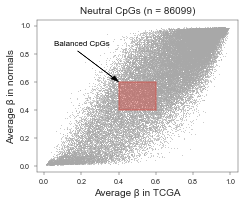

In [55]:
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)

sns.scatterplot(ax=ax, x=data['tumor']['beta_means'].loc[neutral_DNA_CpG_list],
                y=data['normal']['beta_means'].loc[neutral_DNA_CpG_list], s = 5 * sf**2,
                color=consts['palette_jco'][2], alpha=opacity
               )
ax.set_xlabel('Average β in TCGA', fontsize=labelfontsize * sf)
ax.set_ylabel('Average β in normals', fontsize=labelfontsize * sf)
ax.set_title(f'Neutral CpGs (n = {len(neutral_DNA_CpG_list)})', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)
            
lower = 0.4
upper = 0.6

ax.fill([lower, upper, upper, lower], [lower, lower, upper, upper],
        color=consts['palette_jco'][3], alpha=0.5, lw=4 * sf)

ax.text(0.35, 0.85, 'Balanced CpGs',
        ha="right", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=labelfontsize * 0.8 * sf)

ax.arrow(0.18, 0.82, 0.22, -0.22, color='black', length_includes_head=True, head_width=0.03, lw=0.5)

fig.savefig(os.path.join(figure_outdir, 'Figure_2_A.pdf'), format='pdf', pad_inches=0.1)

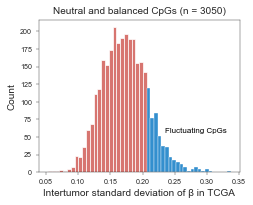

In [60]:
## new figure

fig, ax = plt.subplots(1, 1, figsize=figsize * sf)

balanced_means_CpGs = local_util.getCpG_list(data, local_util.CLOCK_CRITERIA, starting_CpG_list=neutral_DNA_CpG_list)
balanced_CpGs_final_set
sns.histplot(ax=ax, x=data['tumor']['beta_stds'].loc[balanced_means_CpGs[~np.isin(balanced_means_CpGs, balanced_CpGs_final_set)]],
            color=consts['palette_jco'][3], alpha=opacity
            )

sns.histplot(ax=ax, x=data['tumor']['beta_stds'].loc[balanced_CpGs_final_set],
            color=consts['palette_jco'][0], alpha=opacity
            )

ax.set_xlabel('Intertumor standard deviation of β in TCGA', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=labelfontsize * sf)
ax.set_title(f'Neutral and balanced CpGs (n = {len(balanced_means_CpGs)})', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(0.235, 55, 'Fluctuating CpGs',
        ha="left", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=labelfontsize * 0.8 * sf)

fig.savefig(os.path.join(figure_outdir, 'Figure_2_B.pdf'), format='pdf', pad_inches=0.1)

### Display CpG Examples - Figure 2E

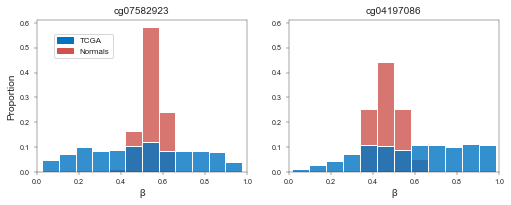

In [27]:
fig, axes = plt.subplots(1, 2, figsize=figsize * sf * [2.3, 1])

CpG_randSamp = np.random.choice(balanced_CpGs_final_set, 2, replace=False)
color_dict = {'TCGA':consts['palette_jco'][0], 'Normals':consts['palette_jco'][3]}
patches = [mpatches.Patch(color=color_dict[cohort], label=cohort) for cohort in color_dict.keys()]

plots_x, plots_y = axes[0].get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper left',
           bbox_to_anchor=(plots_x - .33, plots_y - 0.05),
           fontsize=0.8*labelfontsize * sf
          )

CpGs_chosen = ['cg07582923', 'cg04197086']

ymax_max = 0
for i, CpG in enumerate(CpGs_chosen):
    ax = axes[i]
    
    plot_data = pd.concat([
        pd.DataFrame({'beta':data['tumor']['beta_values_SELECTION'].loc[CpG], 'Cohort':'TCGA'}),
        pd.DataFrame({'beta':data['normal']['beta_values_SELECTION'].loc[CpG], 'Cohort':'Normals'})
    ], axis=0)
    sns.histplot(ax=ax, data=plot_data, x='beta', hue='Cohort',
                 common_norm=False, stat='proportion', palette=color_dict, legend=False, alpha=opacity)
    
    ax.set_xlabel('β', fontsize=labelfontsize * sf)
    ax.set_title(CpG, fontsize=labelfontsize * sf)
    ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

    ymax_max = max(ymax_max, ax.get_ylim()[1])

axes[0].set_ylim(0, ymax_max)
axes[1].set_ylim(0, ymax_max)

axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)

axes[0].set_ylabel(axes[1].get_ylabel(), fontsize=labelfontsize * sf)
axes[1].set_ylabel('')

fig.savefig(os.path.join(figure_outdir, 'Figure_2_E.pdf'), format='pdf', pad_inches=0.1)